https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

In [9]:
!mkdir -p ./data/images/neural-style
!wget https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg -O ./data/images/neural-style/picasso.jpg
!wget https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg -O ./data/images/neural-style/dancing.jpg

--2022-10-17 10:59:02--  https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
pytorch.org (pytorch.org) 해석 중... 185.199.109.153, 185.199.111.153, 185.199.108.153, ...
다음으로 연결 중: pytorch.org (pytorch.org)|185.199.109.153|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 200 OK
길이: 114573 (112K) [image/jpeg]
저장 위치: ‘./data/images/neural-style/picasso.jpg’

./data/images/neura 100%[===================>] 111.89K  --.-KB/s    / 0.03s    

2022-10-17 10:59:02 (3.38 MB/s) - ‘./data/images/neural-style/picasso.jpg’ 저장함 [114573/114573]

--2022-10-17 10:59:02--  https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
pytorch.org (pytorch.org) 해석 중... 185.199.109.153, 185.199.108.153, 185.199.111.153, ...
다음으로 연결 중: pytorch.org (pytorch.org)|185.199.109.153|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 200 OK
길이: 40484 (40K) [image/jpeg]
저장 위치: ‘./data/images/neural-style/dancing.jpg’

./data/images/neura 100%[===================>]  39.54K  --.-KB/s    / 0.01s    

2022-10-17 1

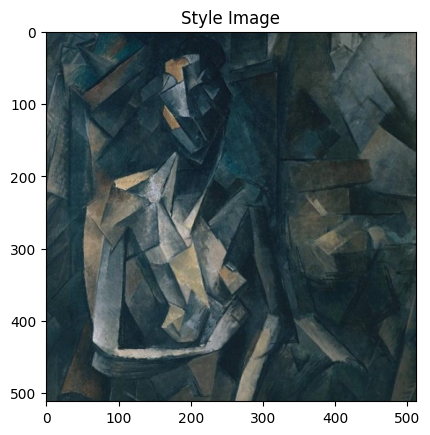

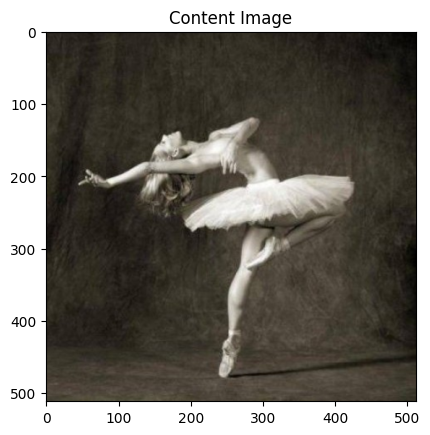

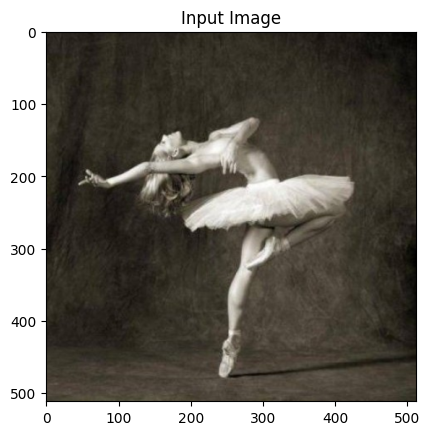

Building the style transfer model..


/tmp/ipykernel_1535820/794804961.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/tmp/ipykernel_1535820/794804961.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 4.322250 Content Loss: 4.130457

run [100]:
Style Loss : 1.181366 Content Loss: 3.029534

run [150]:
Style Loss : 0.728970 Content Loss: 2.656557

run [200]:
Style Loss : 0.484499 Content Loss: 2.497102

run [250]:
Style Loss : 0.351075 Content Loss: 2.405532

run [300]:
Style Loss : 0.264669 Content Loss: 2.348914



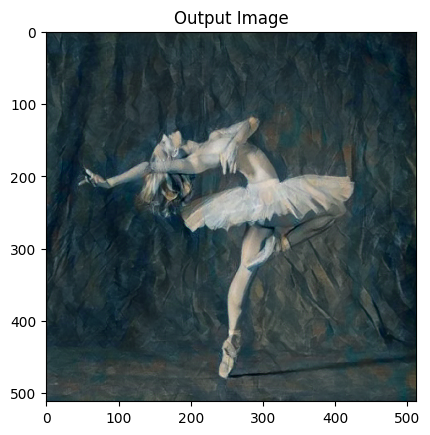

In [12]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name, shape=None):
    image = Image.open(image_name)
    if shape is not None:
        image = image.resize(shape)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./data/images/neural-style/picasso.jpg")
content_img = image_loader("./data/images/neural-style/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

cnn = models.vgg19(pretrained=True).features.to(device).eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer


def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [14]:
!wget "https://upload.wikimedia.org/wikipedia/commons/thumb/7/7c/Les_Premiers_animaux_de_Franz_Marc_%28Mus%C3%A9e_de_l%27Orangerie%2C_Paris%29_%2840833051033%29.jpg/691px-Les_Premiers_animaux_de_Franz_Marc_%28Mus%C3%A9e_de_l%27Orangerie%2C_Paris%29_%2840833051033%29.jpg" \
 -O ./data/images/neural-style/franz-marc.jpg
!wget -O "data/images/neural-style/london-bridge.jpg" "https://pixy.org/src/0/thumbs350/123.jpg"

--2022-10-17 11:09:23--  https://upload.wikimedia.org/wikipedia/commons/thumb/7/7c/Les_Premiers_animaux_de_Franz_Marc_%28Mus%C3%A9e_de_l%27Orangerie%2C_Paris%29_%2840833051033%29.jpg/691px-Les_Premiers_animaux_de_Franz_Marc_%28Mus%C3%A9e_de_l%27Orangerie%2C_Paris%29_%2840833051033%29.jpg
upload.wikimedia.org (upload.wikimedia.org) 해석 중... 103.102.166.240, 2001:df2:e500:ed1a::2:b
다음으로 연결 중: upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 200 OK
길이: 117408 (115K) [image/jpeg]
저장 위치: ‘./data/images/neural-style/franz-marc.jpg’

./data/images/neura 100%[===================>] 114.66K   463KB/s    / 0.2s     

2022-10-17 11:09:23 (463 KB/s) - ‘./data/images/neural-style/franz-marc.jpg’ 저장함 [117408/117408]

--2022-10-17 11:09:23--  https://pixy.org/src/0/thumbs350/123.jpg
pixy.org (pixy.org) 해석 중... 198.37.112.17
다음으로 연결 중: pixy.org (pixy.org)|198.37.112.17|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 200 OK
길이: 130710 (128K) [image/jpe

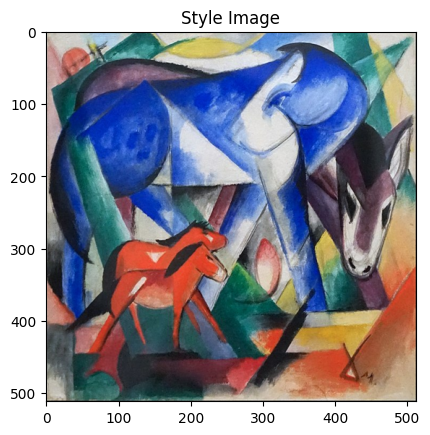

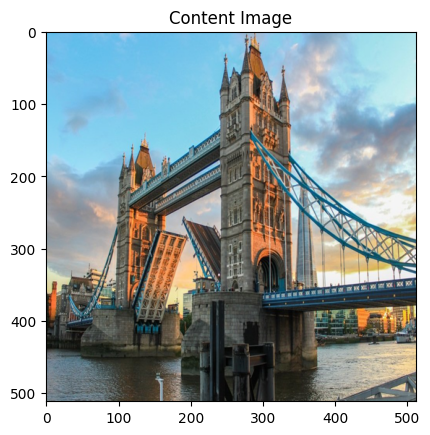

In [55]:
def image_loader(image_name, shape=None):
    image = Image.open(image_name)
    if shape is not None:
        #print(shape)
        #print(image.size)
        image = image.resize(shape)
        #print(image.size)
        
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("./data/images/neural-style/franz-marc.jpg", shape=(512,512))
#print('shape =', tuple(style_img.size()))
#content_img = image_loader("./data/images/neural-style/london-bridge.jpg", shape=(list(style_img.shape)[-1], list(style_img.shape)[-2]))
content_img = image_loader("./data/images/neural-style/london-bridge.jpg", shape=(512,512))
#print(content_img.size())
#print(style_img.size())

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

plt.ion()

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

input_img = content_img.clone()

In [58]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=600)

Building the style transfer model..
Optimizing..


/tmp/ipykernel_1535820/794804961.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/tmp/ipykernel_1535820/794804961.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 1.475924 Content Loss: 7.144085

run [100]:
Style Loss : 1.376752 Content Loss: 6.943377

run [150]:
Style Loss : 1.241854 Content Loss: 6.814355

run [200]:
Style Loss : 1.126300 Content Loss: 6.718060

run [250]:
Style Loss : 1.049182 Content Loss: 6.633335

run [300]:
Style Loss : 1.002090 Content Loss: 6.560989

run [350]:
Style Loss : 0.966810 Content Loss: 6.504752

run [400]:
Style Loss : 0.942650 Content Loss: 6.451911

run [450]:
Style Loss : 0.927830 Content Loss: 6.412300

run [500]:
Style Loss : 0.926426 Content Loss: 6.401634

run [550]:
Style Loss : 0.896074 Content Loss: 6.344779

run [600]:
Style Loss : 0.982599 Content Loss: 6.349782



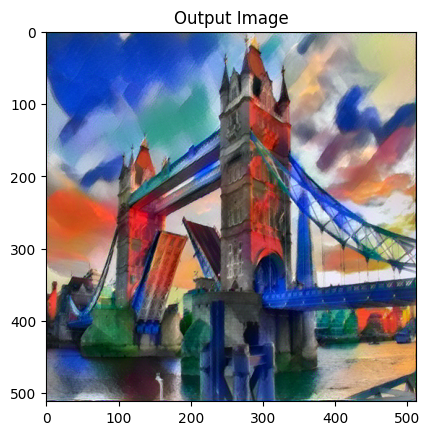

In [59]:
plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

(1024, 1024)
(1024, 1024)


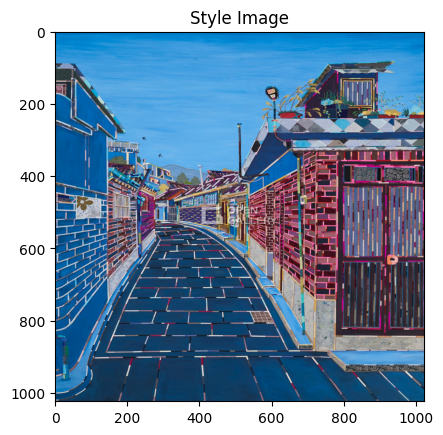

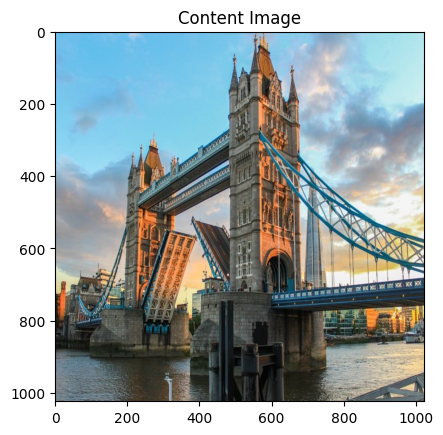

In [68]:
# desired size of the output image
imsize = 1024 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name, shape=None):
    image = Image.open(image_name)
    if shape is not None:
        print(shape)
        image = image.resize(shape)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("./data/images/neural-style/jemiyeong.jpeg", shape=(1024,1024))
content_img = image_loader("./data/images/neural-style/london-bridge.jpg", shape=(1024,1024))

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

plt.ion()

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

input_img = content_img.clone()

In [66]:
content_img.size()

torch.Size([1, 3, 1024, 1605])

In [69]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=600)

Building the style transfer model..
Optimizing..


/tmp/ipykernel_1535820/794804961.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/tmp/ipykernel_1535820/794804961.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 105.311157 Content Loss: 17.475307

run [100]:
Style Loss : 30.481478 Content Loss: 18.242813

run [150]:
Style Loss : 10.635289 Content Loss: 17.483028

run [200]:
Style Loss : 5.990041 Content Loss: 16.062859

run [250]:
Style Loss : 4.151696 Content Loss: 14.965233

run [300]:
Style Loss : 3.092580 Content Loss: 14.259361

run [350]:
Style Loss : 2.329415 Content Loss: 13.730562

run [400]:
Style Loss : 1.862202 Content Loss: 13.371702

run [450]:
Style Loss : 1.550584 Content Loss: 13.102783

run [500]:
Style Loss : 1.292467 Content Loss: 12.884354

run [550]:
Style Loss : 1.130470 Content Loss: 12.703339

run [600]:
Style Loss : 1.144887 Content Loss: 12.562700



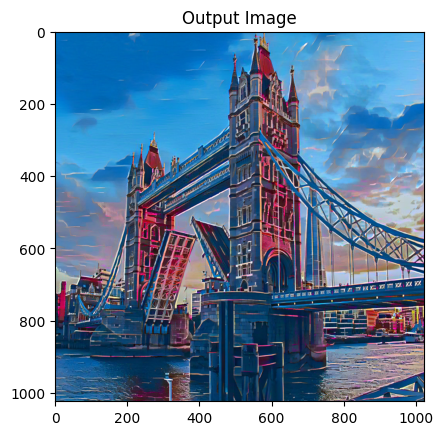

In [70]:
plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [80]:
def save_img(tensor, file_name):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    image = image.resize((1605, 1024))
    image.save(file_name)
save_img(output, 'output.jpg')

In [79]:
org_img = image_loader("./data/images/neural-style/london-bridge.jpg")
org_img.shape

torch.Size([1, 3, 1024, 1605])